**Reference: -** https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding,Dense, Concatenate, TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [8]:
df=pd.read_csv(r'/content/drive/My Drive/clean_data.csv')
df.head()

,Unnamed: 0,Text,Summary
0,0,ad sales boost time warner profit quarterly...,timewarner said fourth quarter sales rose 2% t...
1,1,dollar gains on greenspan speech the dollar...,the dollar has hit its highest level against t...
2,2,yukos unit buyer faces loan claim the owner...,yukos' owner menatep group says it will ask ro...
3,3,high fuel prices hit ba profits british ai...,"rod eddington, ba chief executive, said the r..."
4,4,pernod takeover talk lifts domecq shares in...,pernod has reduced the debt it took on to fund...


In [9]:
df['Text'][0]

'ad sales boost time warner profit    quarterly profits at us media giant timewarner jumped 76% to $1.13bn (â£600m) for the three months to december, from $639m year-earlier.    the firm, which is now one of the biggest investors in google, benefited from sales of high-speed internet connections and higher advert sales. timewarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. its profits were buoyed by one-off gains which offset a profit dip at warner bros, and less users for aol.    time warner said on friday that it now owns 8% of search-engine google. but its own internet business, aol, had has mixed fortunes. it lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. however, the company said aol  underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. it hopes to increase subscribers by offering the online service free to timewarner internet customers and will try to sign

In [10]:
df['Summary'][0]

"timewarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.for the full-year, timewarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn.quarterly profits at us media giant timewarner jumped 76% to $1.13bn (â£600m) for the three months to december, from $639m year-earlier.however, the company said aol  underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.its profits were buoyed by one-off gains which offset a profit dip at warner bros, and less users for aol.for 2005, timewarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.it lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.time warner  fourth quarter profits were slightly better than analysts' expectations."

In [11]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [12]:
df.drop_duplicates(subset=['Text'],inplace=True)

In [13]:
df.isna().sum()

Text       1
Summary    0
dtype: int64

In [14]:
df.dropna(axis=0,inplace=True)

In [15]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stop_words=set(stopwords.words('english'))
def preprocessing(text):
    data=text.lower()
    data=BeautifulSoup(data,'lxml').text
    data=re.sub(r'\([^)]*\)','',data)
    data=re.sub('"',' ',data)
    data=' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in data.split(" ")])
    data=re.sub(r"'s\b","",data)
    data=re.sub(r"[^a-zA-Z]"," ",data)
    tokens=[w for w in data.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return (" ".join(long_words)).strip()
cleaned_text=[]
for t in df['Text']:
    cleaned_text.append(preprocessing(t))     

Simlilarly for Summary

In [19]:
def summary_cleaner(text):
    sum_data = re.sub('"','', text)
    sum_data = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in sum_data.split(" ")])    
    sum_data = re.sub(r"'s\b","",sum_data)
    sum_data = re.sub("[^a-zA-Z]", " ", sum_data)
    sum_data = sum_data.lower()
    tokens=sum_data.split()
    sum_data=''
    for i in tokens:
        if len(i)>1:                                 
            sum_data=sum_data+i+' '  
    return sum_data

cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [20]:
df.head()

,Text,Summary,cleaned_text,cleaned_summary
0,ad sales boost time warner profit quarterly...,timewarner said fourth quarter sales rose 2% t...,sales boost time warner profit quarterly profi...,timewarner said fourth quarter sales rose to b...
1,dollar gains on greenspan speech the dollar...,the dollar has hit its highest level against t...,dollar gains greenspan speech dollar hit highe...,the dollar has hit its highest level against t...
2,yukos unit buyer faces loan claim the owner...,yukos' owner menatep group says it will ask ro...,yukos unit buyer faces loan claim owners embat...,yukos owner menatep group says it will ask ros...
3,high fuel prices hit ba profits british ai...,"rod eddington, ba chief executive, said the r...",high fuel prices hit profits british airways b...,rod eddington ba chief executive said the resu...
4,pernod takeover talk lifts domecq shares in...,pernod has reduced the debt it took on to fund...,pernod takeover talk lifts domecq shares drink...,pernod has reduced the debt it took on to fund...


In [21]:
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [22]:
for i in range(5):
    print("Text",i,":",df['cleaned_text'][i])
    print()
    print("Summary",i,":",df['cleaned_summary'][i])
    print("\n")

Text 0 : sales boost time warner profit quarterly profits media giant timewarner jumped three months december year earlier firm one biggest investors google benefited sales high speed internet connections higher advert sales timewarner said fourth quarter sales rose profits buoyed one gains offset profit dip warner bros less users aol time warner said friday owns search engine google internet business aol mixed fortunes lost subscribers fourth quarter profits lower preceding three quarters however company said aol underlying profit exceptional items rose back stronger internet advertising revenues hopes increase subscribers offering online service free timewarner internet customers try sign aol existing customers high speed broadband timewarner also restate results following probe securities exchange commission close concluding time warner fourth quarter profits slightly better analysts expectations film division saw profits slump helped box office flops alexander catwoman sharp contra

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
text_word_count=[]
summary_word_count=[]
for lines in df['cleaned_text']:
    text_word_count.append(len(lines.split()))
for lin in df['cleaned_summary']:
    summary_word_count.append(len(lin.split()))

In [25]:
print(summary_word_count)

[133, 162, 126, 186, 105, 66, 131, 158, 94, 92, 80, 132, 116, 169, 280, 106, 86, 55, 89, 253, 145, 102, 77, 141, 218, 134, 105, 70, 151, 169, 138, 128, 87, 119, 93, 137, 168, 43, 86, 120, 138, 102, 97, 169, 151, 109, 121, 115, 256, 116, 128, 216, 112, 97, 167, 99, 208, 116, 133, 65, 96, 119, 92, 153, 136, 119, 113, 145, 237, 92, 87, 120, 103, 99, 80, 125, 191, 94, 94, 89, 116, 99, 231, 93, 96, 90, 148, 72, 158, 156, 139, 148, 119, 87, 74, 46, 211, 90, 185, 166, 152, 89, 168, 143, 93, 156, 106, 85, 64, 122, 212, 110, 175, 162, 66, 103, 168, 75, 206, 127, 228, 171, 77, 79, 117, 172, 219, 163, 75, 173, 216, 90, 138, 160, 173, 224, 105, 131, 120, 208, 128, 142, 83, 90, 112, 390, 90, 120, 274, 157, 129, 140, 175, 169, 115, 123, 105, 51, 318, 149, 154, 103, 190, 177, 151, 128, 102, 131, 83, 93, 99, 165, 154, 126, 85, 138, 138, 120, 71, 145, 243, 111, 358, 137, 121, 90, 118, 166, 154, 125, 216, 179, 106, 73, 191, 126, 109, 136, 167, 230, 100, 155, 130, 204, 114, 133, 149, 113, 212, 168, 110, 

In [26]:
text_word_count.sort(reverse=True)
summary_word_count.sort(reverse=True)

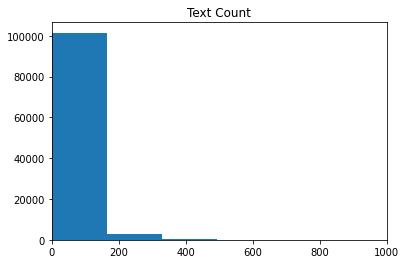

In [27]:
plt.hist(text_word_count,bins=40)
plt.title('Text Count')
plt.xlim([0,1000])
plt.show()

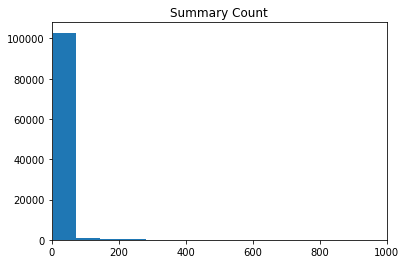

In [28]:
plt.hist(summary_word_count,bins=30)
plt.title('Summary Count')
plt.xlim([0,1000])
plt.show()

Text and summary are almost equal

In [29]:
max_len_text=180
max_len_summary=100

In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.2,random_state=32,shuffle=True)

Embeddings

In [31]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train    =   x_tokenizer.texts_to_sequences(x_train) 
x_test  =   x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_train    =   pad_sequences(x_train,  maxlen=max_len_text, padding='post') 
x_test   =   pad_sequences(x_test, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train    =   y_tokenizer.texts_to_sequences(y_train) 
y_test   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_test   =   pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

Model Building LSTM

In [32]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [45]:
from keras import backend as K 
K.clear_session() 
latent_dim = 100

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 180, 100)     8729300     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 180, 100), ( 80400       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_train,y_train[:,:-1]], 
                  y_train.reshape(y_train.shape[0],
                 y_train.shape[1], 1)[:,1:] ,
                  epochs=5,
                  callbacks=[es],
                  batch_size=32, 
                  validation_data=([x_test,y_test[:,:-1]],
                  y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/5
2621/2621 [==============================] - 1194s 455ms/step - loss: 1.0533 - val_loss: 0.9645
Epoch 2/5
 976/2621 [==========>...................] - ETA: 12:05 - loss: 0.9627

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() pyplot.show()

Testing Phase

In [ ]:
# encoder
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder 

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
   
    e_out, e_h, e_c = encoder_model.predict(input_seq)

  
    target_seq = np.zeros((1,1))

    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")